# Problem 8b

/home/kimaruboruett/Documents/Swarthmore/spring-2025/nonlinear-dynamics-chaos/labs/venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


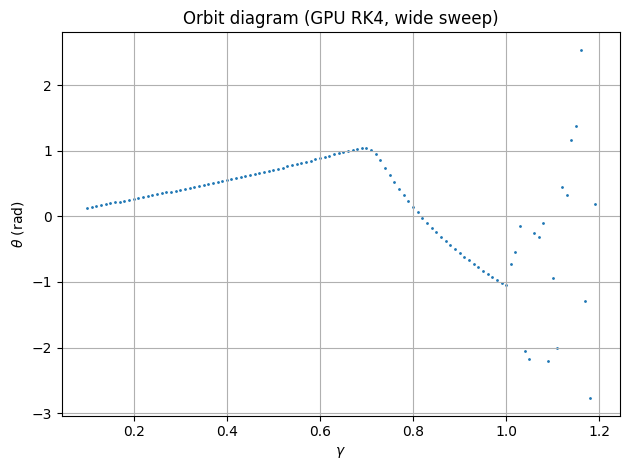

In [1]:
# orbit_diagram_cuda_wide.py
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float64

# ---------- GPU kernel ----------
@cuda.jit
def rk4_kernel(gammas, t0, t_end, dt, theta_out):
    tid = cuda.grid(1)                     # one thread  per gamma
    if tid >= gammas.size:
        return

    g   = gammas[tid]
    w   = 2*np.pi
    w0  = 1.5*w
    b   = 0.25*w0

    # state  (θ, θ̇, φ)
    th   = 0.5*np.pi
    thd  = 0.0
    phi  = 0.0

    nsteps = int((t_end - t0)/dt)
    for n in range(nsteps):
        # RK4 in-line -------------------------------------------------
        def f(theta, thetad, phi_):
            k1 = thetad
            k2 = g*w0*w0*np.cos(phi_) - 2*b*thetad - w0*w0*np.sin(theta)
            return k1, k2, w

        k1_th,  k1_thd,  k1_phi  = f(th,              thd,              phi)
        k2_th,  k2_thd,  k2_phi  = f(th+0.5*dt*k1_th, thd+0.5*dt*k1_thd, phi+0.5*dt*k1_phi)
        k3_th,  k3_thd,  k3_phi  = f(th+0.5*dt*k2_th, thd+0.5*dt*k2_thd, phi+0.5*dt*k2_phi)
        k4_th,  k4_thd,  k4_phi  = f(th+dt*k3_th,     thd+dt*k3_thd,     phi+dt*k3_phi)

        th  += dt/6*(k1_th + 2*k2_th + 2*k3_th + k4_th)
        thd += dt/6*(k1_thd+ 2*k2_thd+ 2*k3_thd+ k4_thd)
        phi += dt/6*(k1_phi+ 2*k2_phi+ 2*k3_phi+ k4_phi)
    # ---------------------------------------------------------------

    # store wrapped angle from last step
    theta_out[tid] = (th + np.pi) % (2*np.pi) - np.pi


# ---------- host side ----------
def main():
    gammas = np.arange(0.10, 1.20, 0.01, dtype=np.float64)
    d_g    = cuda.to_device(gammas)
    d_theta= cuda.device_array_like(gammas)

    dt     = 0.01
    t0, tf = 0.0, 500.0

    threads = 128
    blocks  = (gammas.size + threads - 1)//threads
    rk4_kernel[blocks, threads](d_g, t0, tf, dt, d_theta)

    theta = d_theta.copy_to_host()

    plt.scatter(gammas, theta, s=1)
    plt.xlabel(r'$\gamma$'); plt.ylabel(r'$\theta$ (rad)')
    plt.title('Orbit diagram (GPU RK4, wide sweep)')
    plt.grid(True); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()


# Problem 8c

/home/kimaruboruett/Documents/Swarthmore/spring-2025/nonlinear-dynamics-chaos/labs/venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


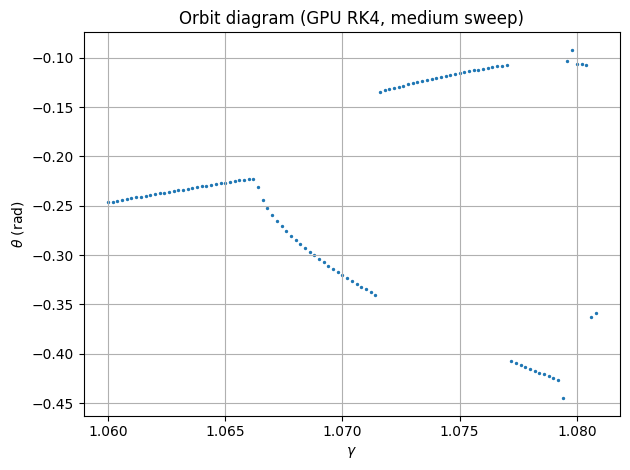

In [2]:
# orbit_diagram_cuda_medium.py
import numpy as np, matplotlib.pyplot as plt
from numba import cuda, float64

@cuda.jit
def rk4_kernel(gam, dt, steps, theta_out):
    tid = cuda.grid(1)
    if tid >= gam.size:
        return
    g   = gam[tid]
    w   = 2*np.pi;  w0 = 1.5*w;  b = 0.25*w0
    th, thd, ph = 0.5*np.pi, 0.0, 0.0

    for _ in range(steps):
        def f(t_, td_, p_):
            return (td_,
                    g*w0*w0*np.cos(p_) - 2*b*td_ - w0*w0*np.sin(t_),
                    w)
        k1 = f(th,                 thd,                 ph)
        k2 = f(th+0.5*dt*k1[0], thd+0.5*dt*k1[1], ph+0.5*dt*k1[2])
        k3 = f(th+0.5*dt*k2[0], thd+0.5*dt*k2[1], ph+0.5*dt*k2[2])
        k4 = f(th+dt*k3[0],     thd+dt*k3[1],     ph+dt*k3[2])
        th  += dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
        thd += dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1])
        ph  += dt/6*(k1[2]+2*k2[2]+2*k3[2]+k4[2])
    theta_out[tid] = (th+np.pi)%(2*np.pi)-np.pi


def main():
    gammas = np.arange(1.060, 1.081, 0.0002, dtype=np.float64)
    steps  = int((500.0-0.0)/0.01)
    d_g    = cuda.to_device(gammas)
    d_th   = cuda.device_array_like(gammas)
    rk4_kernel[(gammas.size+127)//128,128](d_g, 0.01, steps, d_th)
    th = d_th.copy_to_host()

    plt.scatter(gammas, th, s=2)
    plt.xlabel(r'$\gamma$'); plt.ylabel(r'$\theta$ (rad)')
    plt.title('Orbit diagram (GPU RK4, medium sweep)')
    plt.grid(True); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()


# Problem 8d

/home/kimaruboruett/Documents/Swarthmore/spring-2025/nonlinear-dynamics-chaos/labs/venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


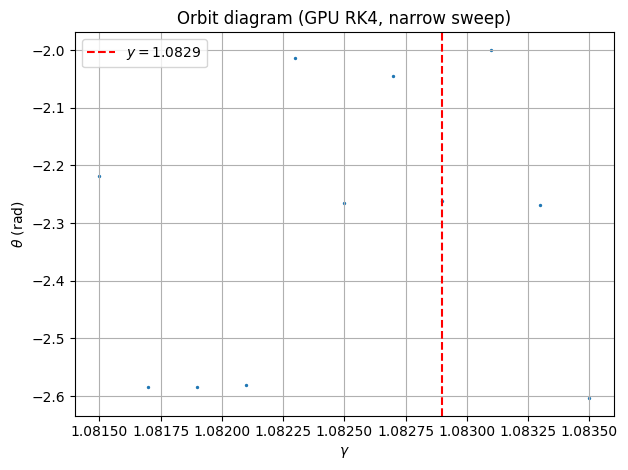

In [3]:
# orbit_diagram_cuda_narrow.py
import numpy as np, matplotlib.pyplot as plt
from numba import cuda, float64

@cuda.jit
def rk_kernel(gam, dt, steps, theta_out):
    i = cuda.grid(1)
    if i >= gam.size: return
    g = gam[i]; w=2*np.pi; w0=1.5*w; b=0.25*w0
    th, thd, ph = 0.5*np.pi, 0.0, 0.0
    for _ in range(steps):
        k1t, k1d = thd, g*w0*w0*np.cos(ph)-2*b*thd-w0*w0*np.sin(th)
        k2t, k2d = thd+0.5*dt*k1d, g*w0*w0*np.cos(ph+0.5*dt*w)-2*b*(thd+0.5*dt*k1d)-w0*w0*np.sin(th+0.5*dt*k1t)
        k3t, k3d = thd+0.5*dt*k2d, g*w0*w0*np.cos(ph+0.5*dt*w)-2*b*(thd+0.5*dt*k2d)-w0*w0*np.sin(th+0.5*dt*k2t)
        k4t, k4d = thd+dt*k3d,   g*w0*w0*np.cos(ph+dt*w)-2*b*(thd+dt*k3d)-w0*w0*np.sin(th+dt*k3t)
        th  += dt/6*(k1t+2*k2t+2*k3t+k4t)
        thd += dt/6*(k1d+2*k2d+2*k3d+k4d)
        ph  += dt*w
    theta_out[i] = (th+np.pi)%(2*np.pi)-np.pi

def main():
    gs = np.arange(1.0815, 1.0836, 0.0002, dtype=np.float64)
    steps = int((500-0)/0.01)
    d_g, d_th = cuda.to_device(gs), cuda.device_array_like(gs)
    rk_kernel[(gs.size+127)//128,128](d_g, 0.01, steps, d_th)
    th = d_th.copy_to_host()

    plt.scatter(gs, th, s=2)
    plt.axvline(1.0829, color='red', ls='--', label=r'$y=1.0829$')
    plt.xlabel(r'$\gamma$'); plt.ylabel(r'$\theta$ (rad)')
    plt.title('Orbit diagram (GPU RK4, narrow sweep)')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()


# Problem 8e γ = 1.086

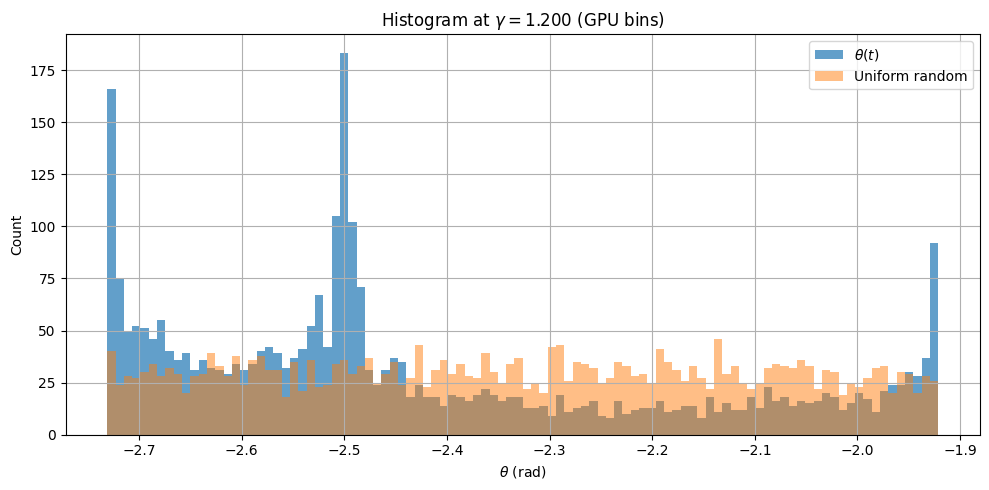

In [4]:
# histogram_theta_cuda.py
import numpy as np, cupy as cp, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def pendulum_rhs(t, v, g):
    w=2*np.pi; w0=1.5*w; b=0.25*w0
    th,thd,ph=v
    return [thd, g*w0*w0*np.cos(ph)-2*b*thd-w0*w0*np.sin(th), w]

γ       = 1.086
t_final = 3100
IC      = [np.pi/2, 0.0, 0.0]
sol     = solve_ivp(pendulum_rhs, [0,t_final], IC, args=(γ,),
                    rtol=1e-9, atol=1e-12, max_step=0.01, dense_output=True)

t  = np.arange(100,t_final,1.0)
θ  = sol.sol(t)[0]

# --- GPU-accelerated random + histogram ----------------------------
rng_gpu   = cp.random.default_rng()
θ_gpu     = cp.asarray(θ)
rnd_gpu   = rng_gpu.uniform(θ_gpu.min(), θ_gpu.max(), 3000, dtype=cp.float64)

bins      = cp.linspace(θ_gpu.min(), θ_gpu.max(), 101)
hist_θ    = cp.histogram(θ_gpu,  bins=bins)[0]
hist_rand = cp.histogram(rnd_gpu, bins=bins)[0]
bins_cpu  = cp.asnumpy(bins)

# plot on CPU
plt.figure(figsize=(10,5))
plt.bar(bins_cpu[:-1], cp.asnumpy(hist_θ),   width=bins_cpu[1]-bins_cpu[0],
        alpha=0.7, label=r'$\theta(t)$')
plt.bar(bins_cpu[:-1], cp.asnumpy(hist_rand),width=bins_cpu[1]-bins_cpu[0],
        alpha=0.5, label='Uniform random')
plt.xlabel(r'$\theta$ (rad)'); plt.ylabel('Count')
plt.title(r'Histogram at $\gamma = 1.200$ (GPU bins)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# Problem 8e γ = 1.200

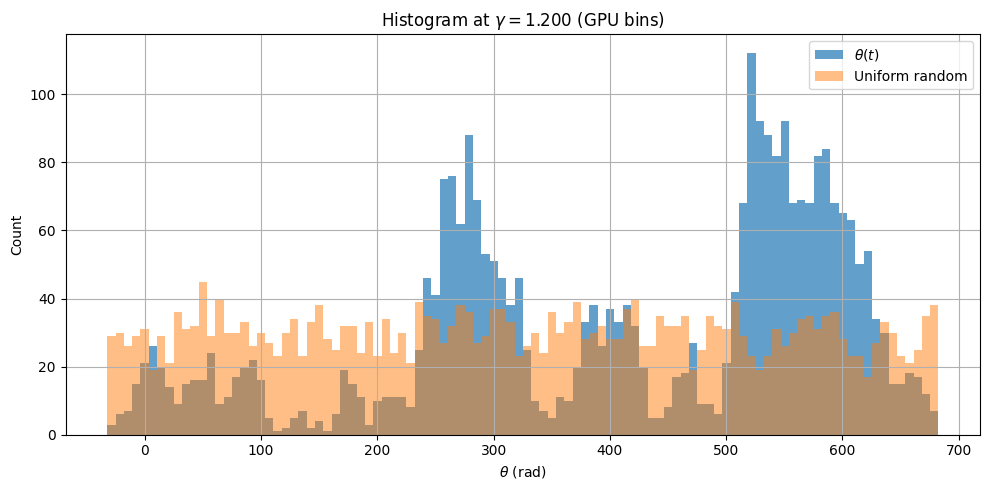

In [5]:
# histogram_theta_cuda.py
import numpy as np, cupy as cp, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def pendulum_rhs(t, v, g):
    w=2*np.pi; w0=1.5*w; b=0.25*w0
    th,thd,ph=v
    return [thd, g*w0*w0*np.cos(ph)-2*b*thd-w0*w0*np.sin(th), w]

γ       = 1.200
t_final = 3100
IC      = [np.pi/2, 0.0, 0.0]
sol     = solve_ivp(pendulum_rhs, [0,t_final], IC, args=(γ,),
                    rtol=1e-9, atol=1e-12, max_step=0.01, dense_output=True)

t  = np.arange(100,t_final,1.0)
θ  = sol.sol(t)[0]

# --- GPU-accelerated random + histogram ----------------------------
rng_gpu   = cp.random.default_rng()
θ_gpu     = cp.asarray(θ)
rnd_gpu   = rng_gpu.uniform(θ_gpu.min(), θ_gpu.max(), 3000, dtype=cp.float64)

bins      = cp.linspace(θ_gpu.min(), θ_gpu.max(), 101)
hist_θ    = cp.histogram(θ_gpu,  bins=bins)[0]
hist_rand = cp.histogram(rnd_gpu, bins=bins)[0]
bins_cpu  = cp.asnumpy(bins)

# plot on CPU
plt.figure(figsize=(10,5))
plt.bar(bins_cpu[:-1], cp.asnumpy(hist_θ),   width=bins_cpu[1]-bins_cpu[0],
        alpha=0.7, label=r'$\theta(t)$')
plt.bar(bins_cpu[:-1], cp.asnumpy(hist_rand),width=bins_cpu[1]-bins_cpu[0],
        alpha=0.5, label='Uniform random')
plt.xlabel(r'$\theta$ (rad)'); plt.ylabel('Count')
plt.title(r'Histogram at $\gamma = 1.200$ (GPU bins)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
